# Analyse des données

## Utilisation
Dans ce notebook, on utilise `spylon` pour exécuter du code Scala.
Pour utiliser le notebook, il faut exécuter les commandes suivantes :
* Installer l'environnement virtuel Python :
  * On utilise Python 3.8.10 `pyenv shell 3.8.10`
  * On utilise Poetry pour la gestion de nos dépendances `poetry install`
* Installer le Kernel Scala :
  * `poetry shell`
  * `python -m spylon_kernel install --user`

Une fois que toutes ces étapes ont été faites, vous pouvez choisir le kernel `spylon-kernel` à l'exécution du notebook.

## Introduction 
Durant cette analyse, on va tenter de répondre à 4 questions que l'on se pose suite au traitement de la masse de données collectées par nos drones.

On va principalement manipuler les données avec Spark en Scala. On prendra la liberté d'utiliser Matplotlib en Python pour afficher des graphique comme le langage est plus adapté pour ce genre de manœuvre.

**Définition d'Alerte :** est une alerte pour un citoyen donné lorsque le PeaceScore dépasse le seuil de 50.

## Charger les données

In [1]:
val PEACESCORE_THRESHOLD = 50

val df = spark.read.csv("hdfs://localhost:9000/drone-reports")
    .withColumnRenamed("_c0","reportId")
    .withColumnRenamed("_c1","peaceWatcherId")
    .withColumnRenamed("_c2","time")
    .withColumnRenamed("_c3","latitude")
    .withColumnRenamed("_c4","longitude")
    .withColumnRenamed("_c5","heardWords")
    .withColumnRenamed("_c6","citizenId")
    .withColumnRenamed("_c7","peaceScores")

    .withColumn("reportId",col("reportId").cast("int"))
    .withColumn("peaceWatcherId",col("peaceWatcherId").cast("int"))
    .withColumn("time",to_timestamp(col("time"), "yyyy-MM-dd HH:mm:ss"))
    .withColumn("latitude",col("latitude").cast("double"))
    .withColumn("longitude",col("longitude").cast("double"))
    .withColumn("citizenId",col("citizenId").cast("int"))
    .withColumn("peaceScores",col("peaceScores").cast("int"))

    df.show()

Intitializing Scala interpreter ...

Spark Web UI available at http://192.168.1.33:4040
SparkContext available as 'sc' (version = 3.2.1, master = local[*], app id = local-1655061712786)
SparkSession available as 'spark'


+--------+--------------+-------------------+------------------+-----------------+----------+---------+-----------+
|reportId|peaceWatcherId|               time|          latitude|        longitude|heardWords|citizenId|peaceScores|
+--------+--------------+-------------------+------------------+-----------------+----------+---------+-----------+
|  941039|        340930|2022-04-27 03:31:39|1.9461451740994147|1.845317417325851|       cat|   345509|         27|
|  941039|        340930|2022-04-27 03:31:39|1.9461451740994147|1.845317417325851|       cat|   757853|         32|
|  941039|        340930|2022-04-27 03:31:39|1.9461451740994147|1.845317417325851|       cat|   235974|         17|
|  941039|        340930|2022-04-27 03:31:39|1.9461451740994147|1.845317417325851|       cat|   539014|         46|
|  941039|        340930|2022-04-27 03:31:39|1.9461451740994147|1.845317417325851|       cat|   694939|         58|
|  941039|        340930|2022-04-27 03:31:39|1.9461451740994147|1.845317

PEACESCORE_THRESHOLD: Int = 50
df: org.apache.spark.sql.DataFrame = [reportId: int, peaceWatcherId: int ... 6 more fields]


In [2]:
import java.time.LocalDate
import java.time.format.DateTimeFormatter
import java.sql.Timestamp

// Obtenir le nombre de jour entre le rapport le ancien et le plus récent
val dateTimeFormat = DateTimeFormatter.ofPattern("yyyy-MM-dd HH:mm:ss.S")
val dateMax = df.select(max("time")).collect()(0)(0)
val dateMin = df.select(min("time")).collect()(0)(0)
val localDateMax = LocalDate.parse(dateMax.toString(), dateTimeFormat)
val localDateMin = LocalDate.parse(dateMin.toString(), dateTimeFormat)
val number_of_days = localDateMax.toEpochDay() - localDateMin.toEpochDay()

import java.time.LocalDate
import java.time.format.DateTimeFormatter
import java.sql.Timestamp
dateTimeFormat: java.time.format.DateTimeFormatter = Value(YearOfEra,4,19,EXCEEDS_PAD)'-'Value(MonthOfYear,2)'-'Value(DayOfMonth,2)' 'Value(HourOfDay,2)':'Value(MinuteOfHour,2)':'Value(SecondOfMinute,2)'.'Fraction(NanoOfSecond,1,1)
dateMax: Any = 2022-06-11 14:37:01.0
dateMin: Any = 2022-01-01 00:36:18.0
localDateMax: java.time.LocalDate = 2022-06-11
localDateMin: java.time.LocalDate = 2022-01-01
number_of_days: Long = 161


## Question 1 : Quels sont les jours de la semaine avec le nombre moyen d'alertes le plus important ?

Cette question permet de savoir quand allouer plus de PeaceMakers durant la semaine et à contrario le moment parfait pour accorder un jour de congé à nos troupes de maintien de la paix.

In [3]:
import org.apache.spark.sql.functions._

val question_1_dataframe = df
    .dropDuplicates("reportId", "citizenId") 
    .filter(col("peaceScores") > PEACESCORE_THRESHOLD) // Retirer les doublons liés à la liste de mots heardWords
    .withColumn("week_day", date_format(col("time"), "E")) // E pour day_of_week
    .groupBy("week_day")
    .count()
    .withColumn("count", col("count") / (number_of_days / 7))
    .withColumnRenamed("count","Nombre d'alertes")

question_1_dataframe.show()
question_1_dataframe.createOrReplaceTempView("question_1_dataframe")

+--------+------------------+
|week_day|  Nombre d'alertes|
+--------+------------------+
|     Sun|10.391304347826088|
|     Mon| 9.695652173913043|
|     Thu| 7.739130434782608|
|     Sat| 8.434782608695652|
|     Wed|  9.73913043478261|
|     Fri|  9.26086956521739|
|     Tue| 8.434782608695652|
+--------+------------------+



import org.apache.spark.sql.functions._
question_1_dataframe: org.apache.spark.sql.DataFrame = [week_day: string, Nombre d'alertes: double]


          Nombre d'alertes
week_day                  
Thu               7.739130
Sat               8.434783
Tue               8.434783
Fri               9.260870
Mon               9.695652
Wed               9.739130
Sun              10.391304


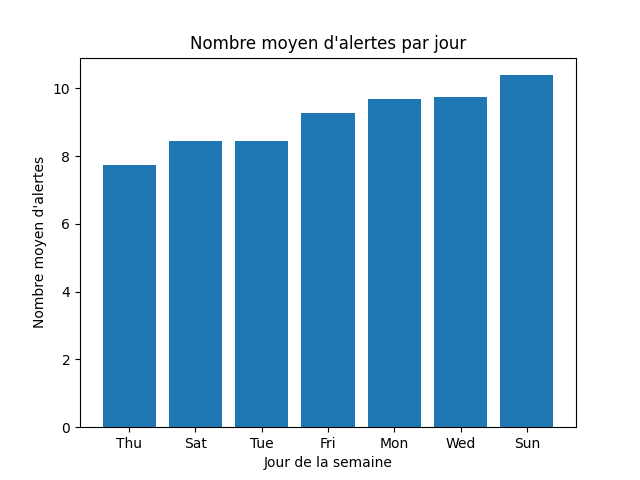

In [4]:
%%python
from matplotlib import pyplot as plt
from IPython.display import Image
import tempfile

df = spark.sql("select * from question_1_dataframe").toPandas()
df = df.set_index(df["week_day"]).drop("week_day", axis=1).sort_values("Nombre d'alertes")
print(df)
plt.clf()
plt.bar(df.index, height=df["Nombre d'alertes"])
plt.title("Nombre moyen d'alertes par jour")
plt.xlabel("Jour de la semaine")
plt.ylabel("Nombre moyen d'alertes")
with tempfile.NamedTemporaryFile(suffix=".png") as graph:
    plt.savefig(graph.name)
    retval = Image(filename=graph.name)


## Question 2 : Quelle est l'évolution de la moyenne des PeaceScores en fonction du mois de l'année ?

Ça nous permettra de connaître le moment dans l'année où la paix est la plus menacée et donc de savoir quel évenement influence le plus l'humeur de nos citoyens. On peut facilement imaginer par exemple que les citoyens soient plus heureux en été grâce au Soleil et moins en Hiver par manque de luminosité.

In [5]:
import org.apache.spark.sql.functions._

val question_2_dataframe = df
    .dropDuplicates("reportId", "citizenId")
    .withColumn("month", date_format(col("time"), "L")) // L pour month en texte
    .groupBy("month")
    .mean("peaceScores")
    .withColumnRenamed("avg(peaceScores)","peaceScores")

question_2_dataframe.show()
question_2_dataframe.createOrReplaceTempView("question_2_dataframe")

+-----+------------------+
|month|       peaceScores|
+-----+------------------+
|    3| 35.67884322678843|
|    5| 35.56191467221644|
|    6|  37.3142144638404|
|    1| 34.31147540983606|
|    4|35.265957446808514|
|    2| 36.44444444444444|
+-----+------------------+



import org.apache.spark.sql.functions._
question_2_dataframe: org.apache.spark.sql.DataFrame = [month: string, peaceScores: double]


### Question intermédiaire : Quel est le moment de la journée où le nombre moyen d'alertes est le plus important ?

Le nombre moyen d'alertes en fonction du moment dans la journée nous permet de savoir quand est-ce que l'on doit mettre plus de moyens pour maintenant la paix. On peut intuitivement imaginer que les citoyens étant moins actifs la nuit, les moyens alloués peuvent être réduits permettant ainsi d'économiser des ressources et aussi beaucoup d'argent.

In [6]:
import org.apache.spark.sql.functions._

val question_2_bis_dataframe = df
    .dropDuplicates("reportId", "citizenId")
    .filter(col("peaceScores") > PEACESCORE_THRESHOLD)
    .withColumn("hour", hour(col("time")))
    .groupBy("hour")
    .count()
    .withColumn("count", col("count") / (number_of_days / 24))
    .withColumnRenamed("count","Nombre d'alertes")

question_2_bis_dataframe.show()
question_2_bis_dataframe.createOrReplaceTempView("question_2_bis_dataframe")

+----+------------------+
|hour|  Nombre d'alertes|
+----+------------------+
|  12|12.333333333333334|
|  22|               6.5|
|   1|11.833333333333334|
|  13|14.333333333333334|
|   6| 9.166666666666666|
|  16|              10.0|
|   3|              11.0|
|  20|              10.0|
|   5| 9.666666666666666|
|  19| 9.333333333333334|
|  15| 6.833333333333333|
|  17| 9.166666666666666|
|   9|13.166666666666666|
|   4|              14.0|
|   8| 9.833333333333334|
|  23| 7.666666666666667|
|   7|              11.0|
|  10| 5.833333333333333|
|  21|              14.0|
|  11| 9.833333333333334|
+----+------------------+
only showing top 20 rows



import org.apache.spark.sql.functions._
question_2_bis_dataframe: org.apache.spark.sql.DataFrame = [hour: int, Nombre d'alertes: double]


      Nombre d'alertes
hour                  
0            10.500000
1            11.833333
2             6.500000
3            11.000000
4            14.000000
5             9.666667
6             9.166667
7            11.000000
8             9.833333
9            13.166667
10            5.833333
11            9.833333
12           12.333333
13           14.333333
14           14.500000
15            6.833333
16           10.000000
17            9.166667
18            7.166667
19            9.333333
20           10.000000
21           14.000000
22            6.500000
23            7.666667


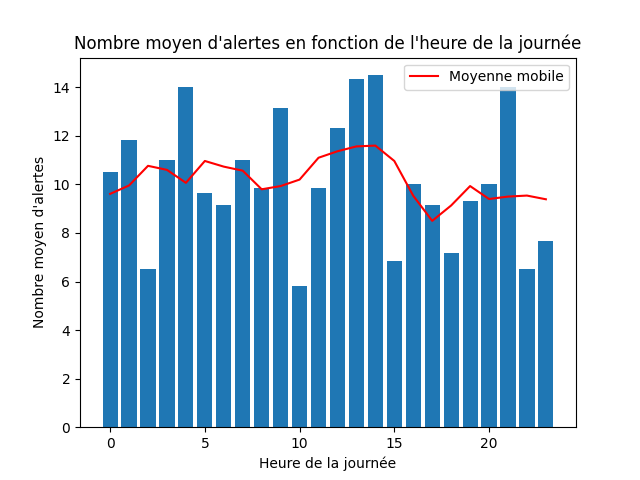

In [7]:
%%python
from matplotlib import pyplot as plt
from IPython.display import Image
import tempfile
import pandas as pd

df = spark.sql("select * from question_2_bis_dataframe").toPandas()
df = df.set_index(df["hour"]).drop("hour", axis=1).sort_index()
print(df)
plt.clf()
plt.bar(df.index, height=df["Nombre d'alertes"])
plt.plot(df.rolling(5, center=True, min_periods=1).mean(), color="red", label="Moyenne mobile")
plt.title("Nombre moyen d'alertes en fonction de l'heure de la journée")
plt.xlabel("Heure de la journée")
plt.ylabel("Nombre moyen d'alertes")
plt.legend()
with tempfile.NamedTemporaryFile(suffix=".png") as graph:
    plt.savefig(graph.name)
    retval = Image(filename=graph.name)

## Question 3 : Dans quelle zone de PeaceLand trouve-t-on le plus souvent des alertes ?

On considère ici que PeaceLand est une zone carrée composée de 4 arrondissements. On cherche à savoir quel arrondissement représente le plus une menace pour la paix de notre communauté. Ça nous permet de savoir comment répartir au mieux nos troupes de maintien de la paix pour qu'elles puissent réagir plus vite et de manière plus efficace.

| **1er arrondissement** | **2e arrondissement** |
|:----------------------:|:---------------------:|
| **3e arrondissement**  | **4e arrondissement** |

In [30]:
import org.apache.spark.sql.functions._

val question_3_dataframe = df
    .dropDuplicates("reportId", "citizenId")
    .filter(col("peaceScores") > PEACESCORE_THRESHOLD) // Retirer les doublons liés à la liste de mots heardWords
    .withColumn("arrondissement", 
        when(col("latitude") >= 0 && col("latitude") <= 1 && col("longitude") >= 0 && col("longitude") <= 1, lit("1er"))
            .when(col("latitude") >= 1 && col("latitude") <= 2 && col("longitude") >= 0 && col("longitude") <= 1, lit("2e"))
            .when(col("latitude") >=  0 && col("latitude") <= 1 && col("longitude") >= 1 && col("longitude") <= 2, lit("3e"))
            .when(col("latitude") >= 1 && col("latitude") <= 2 && col("longitude") >= 1 && col("longitude") <= 2, lit("4e"))
            .otherwise("Aucun")
    ) 
    .groupBy("arrondissement")
    .count()
    .withColumnRenamed("count","Nombre d'alertes")
    .sort(col("Nombre d'alertes").desc)

question_3_dataframe.show()

+--------------+----------------+
|arrondissement|Nombre d'alertes|
+--------------+----------------+
|           1er|             620|
|            2e|             292|
|            3e|             278|
|            4e|             275|
+--------------+----------------+



import org.apache.spark.sql.functions._
question_3_dataframe: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [arrondissement: string, Nombre d'alertes: bigint]


## Question 4 : Quel est le mot associé avec le PeaceScore le plus élevé ?

On peut alors prendre des mesures comme le bannissement définitif de ce mot du dictionnaire ! La Paix est plus importante que le lexique de nos citoyens !

In [8]:
import org.apache.spark.sql.functions._

val question_4_dataframe = df
    .select(col("peaceScores"), col("heardWords"))
    .groupBy("heardWords")
    .mean("peaceScores")
    .withColumnRenamed("avg(peaceScores)","PeaceScore moyen")
    .sort(col("PeaceScore moyen").desc)

question_4_dataframe.show()

+------------+------------------+
|  heardWords|  PeaceScore moyen|
+------------+------------------+
|       nigga| 75.84033613445378|
|        kill| 75.74107142857143|
|        arse| 75.58823529411765|
|        damn| 74.90517241379311|
|        shit| 74.47222222222223|
|        fuck| 74.34782608695652|
|         ass| 74.07377049180327|
|       dummy|            73.125|
|       idiot| 73.11009174311927|
|       bitch| 72.58474576271186|
|     bastard| 72.53846153846153|
|        crap| 72.23636363636363|
|        slut| 71.84848484848484|
|        door|62.529411764705884|
|       hello| 62.50239234449761|
|      street| 61.97692307692308|
|        piss| 61.76704545454545|
|  vegetables| 58.07211538461539|
|      bugger| 58.01754385964912|
|motherfucker|  57.9051724137931|
+------------+------------------+
only showing top 20 rows



import org.apache.spark.sql.functions._
question_4_dataframe: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [heardWords: string, PeaceScore moyen: double]
